In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
weights = [] #coefficients a_0,..., a_N for each current 
lengths = [l]*len(weights) #lengths of each antenna
positions = [(,,)] #position of each antenna (x, y, z)
spacings = [] #separation between each antenna (can be deduced from the position list)

SyntaxError: invalid syntax (3683312590.py, line 3)

In [12]:
I_0 = 1 #for simplicity and could be adapted with weights
eta = 376.7

def U_dipole(k,l,theta):
    U = (eta*k**2)/(32*np.pi**2)*(l**2)*np.sin(theta)**2
    return U

def U_standing_wave(k,l, theta):
    U = (eta)/(8*np.pi**2*np.sin(theta)**2)*(np.cos(np.cos(theta)*(k*l)/2)-np.cos((k*l)/2))**2
    return U

def U_half_wave(k, l, theta):
    k = 2*np.pi
    l= 1/2
    return U_standing_wave(k, l, theta)

def get_U(atype,k,l,theta):
    """
    1: dipole
    2: standing wave
    3: half wave
    """
    if atype == 1:
        return U_dipole(k,l,theta)
    elif atype == 2:
        return U_standing_wave(k,l,theta)
    elif atype == 3:
        return U_half_wave(k,l,theta)
    else:
        return None
    

In [67]:
def convert_in_dB(U):
    return 10*np.log10(U)

# Uniform Arrays

In [185]:
#Uniform spacing
def array_z(k,l, weight, spacing, theta, phi, atype, N):
    U = get_U(atype,k,l,theta)
    k_z = k*np.cos(theta)
    d = spacing
    
    if np.ndim(phi) > 0 and np.ndim(theta) > 0:
        C =  np.ones_like(phi, dtype=complex)
        x = k_z * d / 2
        mask = ~(
        np.isclose(x % np.pi, 0, atol=1e-6)
        )
        C[mask] = (np.sin((k_z[mask]*N*d)/2))/(np.sin(k_z[mask]*d/2))
    elif np.ndim(phi) > 0:
        C =  np.ones_like(phi, dtype=complex)
        mask = (phi != np.pi/2) & (phi != 3*np.pi/2)
        C[mask] = (np.sin((k_z[mask]*N*d)/2))/(np.sin(k_z[mask]*d/2))
    elif np.ndim(theta) > 0:
        C =  np.ones_like(theta, dtype=complex)
        mask = (theta != np.pi) & (theta != 0)
        C[mask] = (1-np.exp(1j*k_z[mask]*N*d))/(1-np.exp(1j*k_z[mask]*d))
    else:
        C = weight*(1-np.exp(1j*k_z*N*d))/(1-np.exp(1j*k_z*d))


def array_x(k,l, weight, spacing, theta, phi, atype, N):
    U = get_U(atype,k,l,theta)
    k_x = k*np.sin(theta)*np.cos(phi)
    d = spacing
    if np.ndim(phi) > 0 and np.ndim(theta) > 0:
        C =  np.ones_like(phi, dtype=complex)
        x = k_x * d / 2
        mask = ~(
        np.isclose(x % np.pi, 0, atol=1e-6)
        )
        C[mask] = (np.sin((k_x[mask]*N*d)/2))/(np.sin(k_x[mask]*d/2))
    elif np.ndim(phi) > 0:
        C =  np.ones_like(phi, dtype=complex)
        mask = (phi != np.pi/2) & (phi != 3*np.pi/2)
        C[mask] = (np.sin((k_x[mask]*N*d)/2))/(np.sin(k_x[mask]*d/2))
    elif np.ndim(theta) > 0:
        C =  np.ones_like(theta, dtype=complex)
        mask = (theta != np.pi) & (theta != 0)
        C[mask] = (1-np.exp(1j*k_x[mask]*N*d))/(1-np.exp(1j*k_x[mask]*d))
    else:
        C = weight*(1-np.exp(1j*k_x*N*d))/(1-np.exp(1j*k_x*d))
    
    return abs(C)**2*U


## Along x

In [186]:
def plot_array_2D_phi(k, l, weight, spacing, atype, N): #uniform spacing + same weight
    """
    k: wavenumber
    l: length of every antenna !in units of lambda!
    weight: coeff a_n
    spacing: distance between each antenna !in units of lambda!
    atype: type of antenna
    N: number of antenna
    """
    wavelength = 2*np.pi/k
    d = spacing*wavelength
    l = l*wavelength
    theta = np.pi/2 #np.linspace(0, np.pi, 500)
    phi = np.linspace(0, 2*np.pi, 500)
    U_tot = array_x(k, l, weight, d, theta, phi, atype, N)
    U_dB = convert_in_dB(U_tot)
    U_tot = U_tot/ np.max(U_tot)
    
    
    #plot
    plt.figure(figsize=(10, 6))
    plt.plot(np.degrees(phi), U_tot, linewidth=2)
    plt.title(f'Normalized Array Factor (N = {N}, d = {spacing}λ)', fontsize=14)
    plt.xlabel(r'$\phi$ (degrees)')
    plt.ylabel('Normalized U')
    plt.grid(True)
    plt.ylim(0, 1.5)
    #plt.xlim(0, 180)
    #plt.axhline(-3, color='red', linestyle='--', label='-3 dB')
    plt.legend()
    plt.show()
    
    #plot dB
    plt.figure(figsize=(10, 6))
    plt.plot(np.degrees(phi), U_dB, linewidth=2)
    plt.title(f'Normalized Array Factor (N = {N}, d = {spacing}λ)', fontsize=14)
    plt.xlabel(r'$\phi$ (degrees)')
    plt.ylabel('Normalized U (dB)')
    plt.grid(True)
    #plt.ylim(0, 1.5)
    #plt.xlim(0, 180)
    #plt.axhline(-3, color='red', linestyle='--', label='-3 dB')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


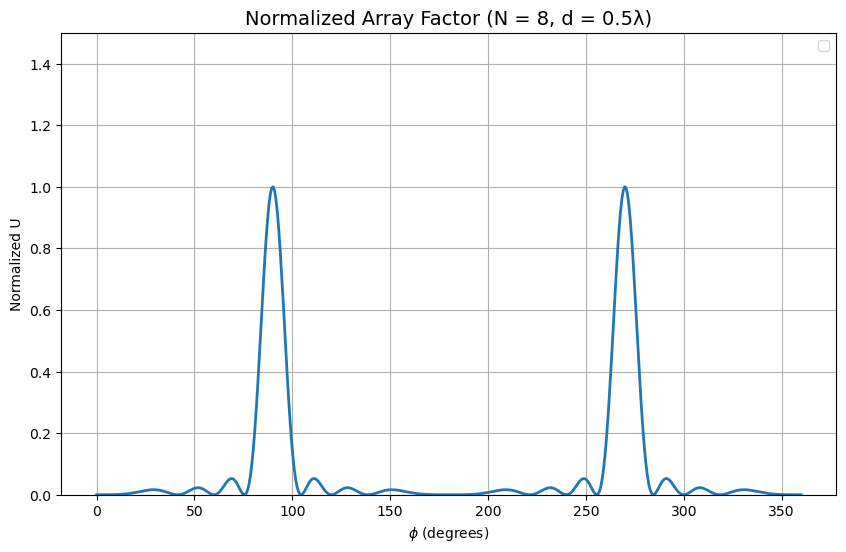

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


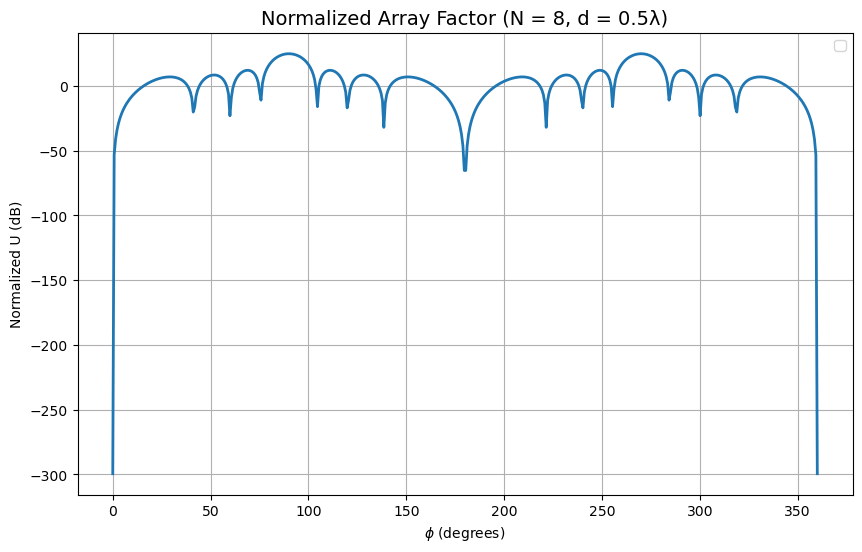

In [141]:
plot_array_2D_phi(1, 1, 1/8, 0.5, 1, 8)

In [278]:
def find_beamwidth(U, phi):
    """
    U must be normalized
    U: radiation intensity array taking values for each phi
    
    """
    #Normalize U in case
    U = U/np.max(U)
    intensity = U
    
    # Find -3 dB beamwidth (half-power points, i.e., intensity >= 0.5)
    threshold = 0.5
    above_threshold = np.where(intensity >= threshold)[0]
    
    if len(above_threshold) == 0:
        print("No beamwidth found, signal may be too weak or improperly defined.")
        return None, None
 
    
    # Find where there are gaps (non-continuous parts)
    diffs = np.diff(above_threshold)
    splits = np.where(diffs > 1)[0]  # Identify where the gaps are
    
    # If there are no gaps, the whole array is continuous
    if len(splits) == 0:
        beam_idx = above_threshold
    else:
        # Split into continuous segments and find the longest one
        blocks = np.split(above_threshold, splits + 1)
        beam_idx = min(blocks, key=len)
        
    
    # Find the angles corresponding to the continuous region
    phi_beam = phi[beam_idx]
    beamwidth_deg = np.degrees(phi_beam[-1] - phi_beam[0])
    
    return phi_beam[0],  phi_beam[-1], beamwidth_deg

In [314]:
def plot_array_2D_phi2(k, l, weight, spacing, atype, N, s): #polar plot
    """
    k: wavenumber
    l: length of each antenna element !in units of lambda!
    weight: array of weights (a_n)
    spacing: distance between antennas !in units of lambda!
    atype: type of antenna (not used in this snippet)
    N: number of antennas
    s: string to 'save' (or not) the figures
    """
    wavelength = 2*np.pi/k
    d = spacing*wavelength
    l = l*wavelength
    theta = np.pi / 2  # Fixed elevation angle (XY-plane cut)
    phi = np.linspace(0, 2 * np.pi, 500)  # Azimuthal angle
    
    # Compute array factor or total radiation pattern
    U_tot = array_x(k, l, weight, d, theta, phi, atype, N)
    
    #comparison with single antenna
    U = np.ones_like(phi, dtype=complex)*get_U(atype,k,l,theta)
    U = abs(U)
    U = U/np.max(U_tot)
    U_dB2 = np.maximum(convert_in_dB(U), -20)
    U_dB2 = (U_dB2 + 20) / 20
    
    #Normalize
    U_tot = np.abs(U_tot)
    U_tot = U_tot / np.max(U_tot)  # Normalize for plotting
    
    #dB
    U_dB = np.maximum(convert_in_dB(U_tot), -20)
    U_dB = (U_dB + 20) / 20

    #beamwidth
    phi_0, phi_1, beamwidth_deg = find_beamwidth(U_tot, phi)
    beamwidth_deg = round(beamwidth_deg, 1)
    
    # Polar plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(phi, U_tot, linewidth=1, label='Radiation intensity Arrays')
    ax.plot(phi, U, 'r--', linewidth = 1, label='Radiation intensity single antenna')

    
    # Highlight -3 dB points
    ax.plot([phi_0, phi_1], [0.5, 0.5], 'go', label='-3 dB Points')
    ax.plot(np.linspace(phi_0, phi_1, 100), [0.5]*100, 'g--', label=f'HPBW Beamwidth Arc, \nBeamwidth={beamwidth_deg}°')

    ax.set_title(f'Normalized Radiation Pattern\nN={N}, d={spacing}λ', va='bottom', fontsize=14)
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Optional: radius ticks
    ax.grid(True)
    ax.legend()
    
    if s == 'save':
        filename = f'C:\\Users\\mattc\\OneDrive\\Documents\\Arrays figures\\xArray_N_{N:.0f}_d_{spacing:.2f}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Polar plot dB
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(phi, U_dB, linewidth=1, label='Radiation intensity Arrays')
    ax.plot(phi, U_dB2, 'r--', linewidth = 1, label='Radiation intensity single antenna')
    

    ax.set_title(f'Normalized Radiation Pattern (in dB)\nN={N}, d={spacing}λ', va='bottom', fontsize=14)
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Optional: radius ticks
    ax.grid(True)
    ax.legend()
    
    #save 2
    if s == 'save':
        filename = f'C:\\Users\\mattc\\OneDrive\\Documents\\Arrays figures\\xpolarArray_N_{N:.0f}_d_{spacing:.2f}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

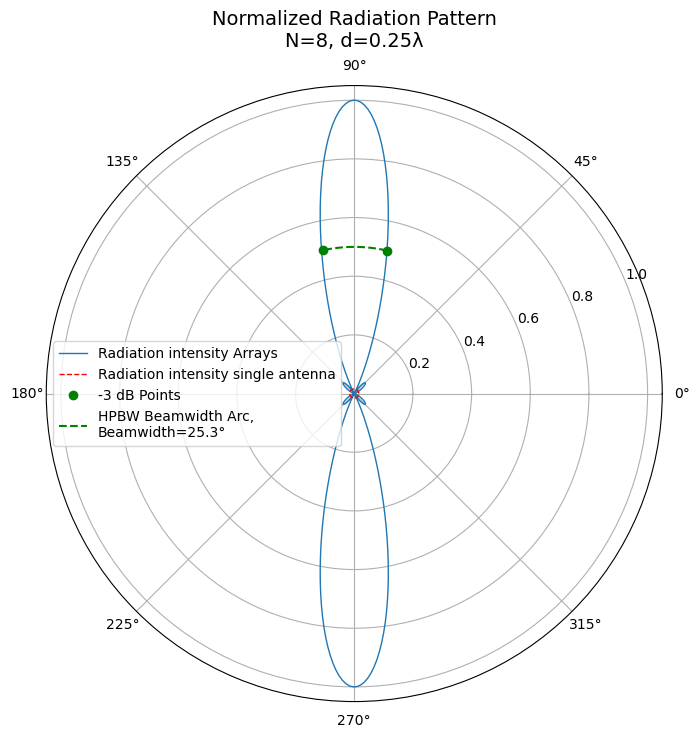

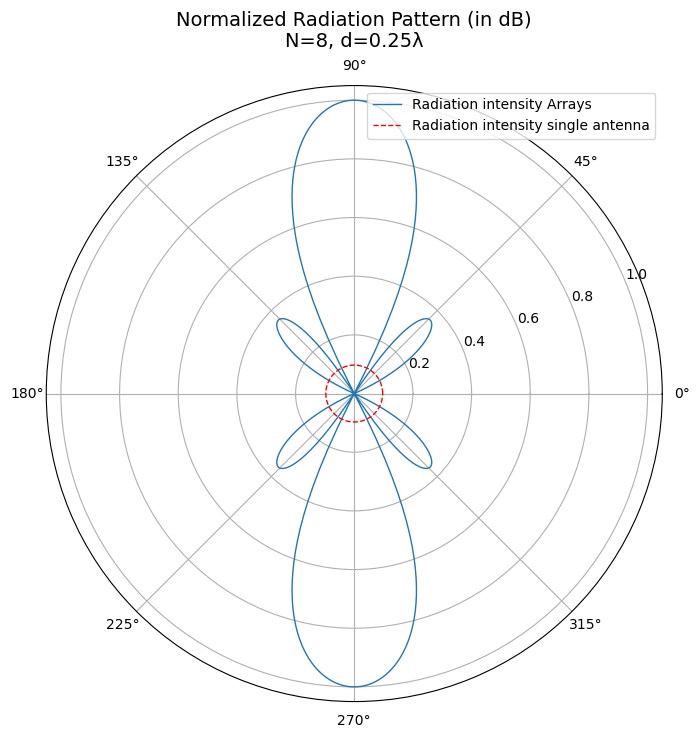

In [318]:
plot_array_2D_phi2(1, 1, 1/8, 0.25, 3, 8, 'saven')

In [299]:
from mpl_toolkits.mplot3d import Axes3D

def plot_array_3D(k, l, weight, spacing, atype, N):
    """
    3D plot of the array factor over theta and phi.
    """
    # Angular grid
    theta = np.linspace(0, np.pi, 200)  # elevation angle
    phi = np.linspace(0, 2 * np.pi, 200)  # azimuthal angle
    THETA, PHI = np.meshgrid(theta, phi)

    # Flatten angles to evaluate function
    theta_flat = THETA.ravel()
    phi_flat = PHI.ravel()

    # Evaluate array factor on the grid
    wavelength = 2*np.pi/k
    d = spacing*wavelength
    l = l*wavelength
    print(k*l == 2*np.pi)
    U_flat = array_x(k, l, weight, d, theta_flat, phi_flat, atype, N)
    U = np.abs(U_flat).reshape(THETA.shape)
    U = U / np.max(U)  # Normalize

    # Convert to Cartesian for plotting
    X = U * np.sin(THETA) * np.cos(PHI)
    Y = U * np.sin(THETA) * np.sin(PHI)
    Z = U * np.cos(THETA)

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis(U), rstride=1, cstride=1, linewidth=0, antialiased=False)

    ax.set_title(f'3D Normalized Radiation Pattern (N = {N}, d = {spacing}λ)', fontsize=14)
    ax.set_box_aspect([1,1,1])
    plt.tight_layout()
    
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    
    plt.show()


True


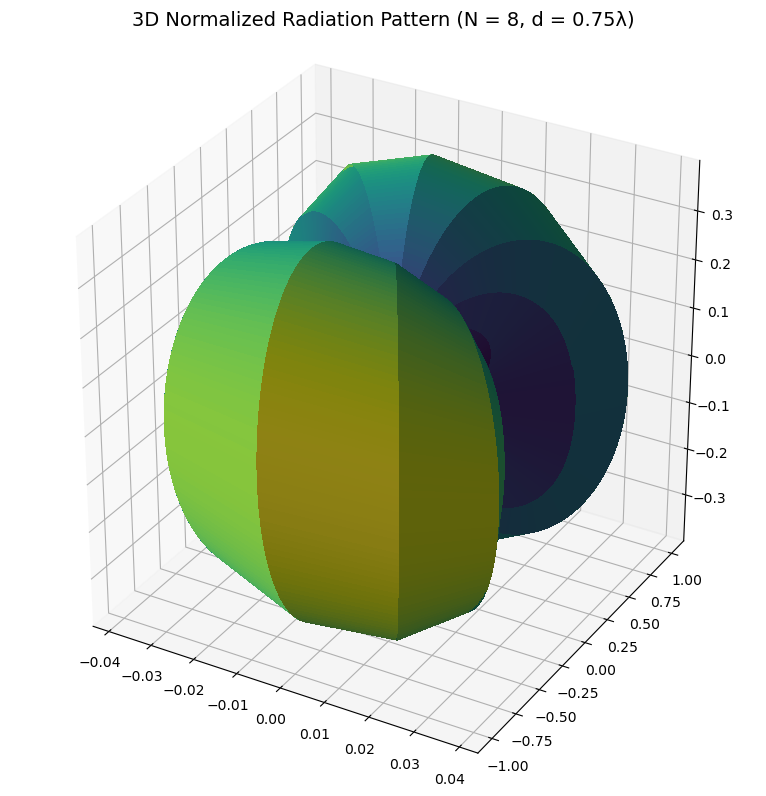

In [298]:
plot_array_3D(1, 1, 1/8, 0.75, 1, 8)

### Directivity

In [308]:
weights = [1]*8 #ex for uniform array with 8 antennas
import numpy as np

def max_directivity(k, weights, spacing):
    """
    weights: list or array of complex weights for each antenna
    spacing: spacing between each element of the array, in units of λ (lambda)
    """
    weights = np.array(weights, dtype=np.complex128)
    wavelength = 2 * np.pi / k
    d = spacing * wavelength

    # Compute numerator: |sum(weights)|^2
    numerator = abs(np.sum(weights))**2  # Eq. 22.8.1

    # Setup for double sum
    N = len(weights)
    n = np.arange(N)
    m = np.arange(N)
    N_grid, M_grid = np.meshgrid(n, m)

    delta = N_grid - M_grid
    kd_delta = k * d * delta

    # Handle sinc safely
    sinc_matrix = np.ones_like(kd_delta, dtype=np.complex128)
    mask = kd_delta != 0
    sinc_matrix[mask] = np.sin(kd_delta[mask]) / kd_delta[mask]

    # Outer product of weights
    A = np.outer(weights, np.conj(weights))

    # Denominator
    denominator = np.sum(A * sinc_matrix)

    # Final directivity
    D = numerator / denominator
    return D.real  # Often directivity is real; discard tiny imaginary parts if any


In [309]:
max_directivity(1, weights, 1)

8.0

# General Array

In [332]:
def C_k(k,l, weights, positions, theta, phi):
    """
    k: wavenumber
    l: length of the antennas !in units of lambda!
    weights: list of each weight a_n
    positions: list of position of each antenna (x, y, z) !coordinates in units of lambda!
    """
    N = len(weights) #length of the array i.e number of element in the array
    k_x = k*np.sin(theta)*np.cos(phi)
    k_y = k*np.sin(theta)*np.sin(phi)
    k_z = k*np.cos(theta)
    wavelength = 2*np.pi/k
    C = 0
    for n in range(0, N):
        x = positions[n][0]*wavelength
        y = positions[n][1]*wavelength
        z = positions[n][2]*wavelength
        term1 = k_x*x
        term2 = k_y*y
        term3 = k_z*z
        C += weights[n]*np.exp(1j*(term1+term2+term3))
        
    
    return C

def power_gain(k,l, weights, positions, theta, phi, atype):
    """
    atype: antenna type(0: power gain only 1: dipole, 2: standing wave antenna, 3: half wave antenna)
    """
    C = C_k(k,l, weights, positions, theta, phi)
    C = abs(C)**2
    if atype != 0:
        U = get_U(atype,k,l,theta)
        C = U*C
    return C

def power_gain_dB(g):
    g = np.maximum(convert_in_dB(g), -20)
    g = (g + 20) / 20
    return g #normalized

In [333]:
def plot_powergain_2D(k, l, weights, positions, atype):
    theta = np.pi/2 
    phi = np.linspace(0, 2*np.pi, 400)
    g = power_gain(k, l, weights, positions, theta, phi, atype)
    g = g/np.max(g)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(phi, g, linewidth=1)
    
    ax.set_title(f'Normalized Radiation Pattern')
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Optional: radius ticks
    ax.grid(True)
    
    ax.legend()
    plt.show()
    
    #Now in dB
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(phi, power_gain_dB(g), linewidth=1)
    
    ax.set_title(f'Normalized Radiation Pattern (dB)')
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Optional: radius ticks
    ax.grid(True)
    
    ax.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


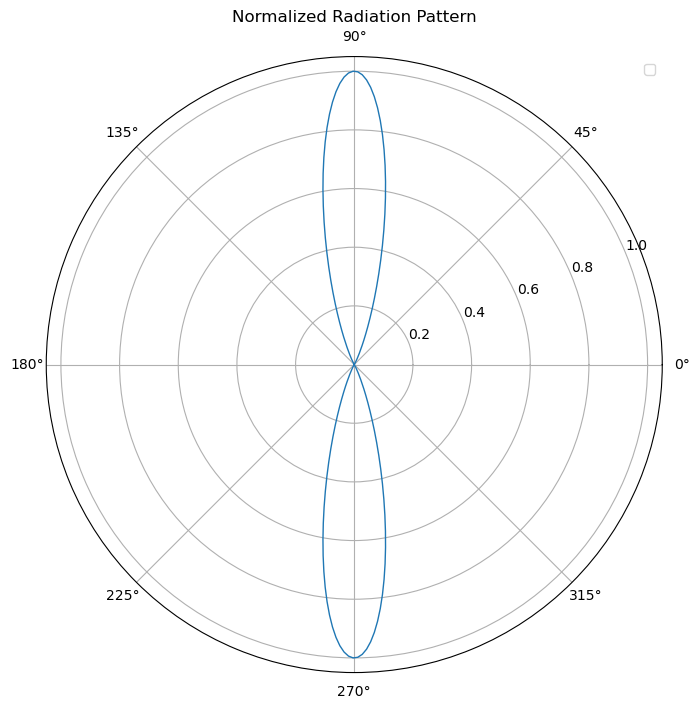

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


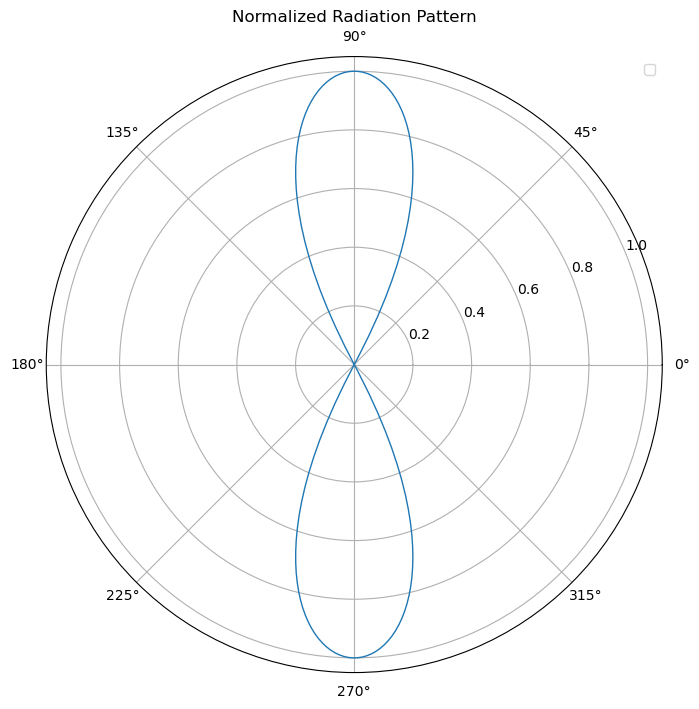

In [335]:
N = 8
d = 0.5
weights = [0.5 * (1 - np.cos(2*np.pi*n/(N-1))) for n in range(N)] #example weights = [1]*N
positions = [(n*d, 0, 0) for n in range(N)]
k = 1
l= 1
plot_powergain_2D(k, l, weights, positions, 0)